In [130]:
from mnist import MNIST
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.insert(0, '../../Libraries')
import JacksonsTSPackage as jts
from statsmodels.tsa.api import VAR

In [634]:
np.random.seed(123)
data = [np.random.uniform(0, 1) + 5]

N = 2000

e = 0.22
for i in range(1, N):
    data.append(data[i-1] + np.random.uniform(-e, e))

data = pd.DataFrame(data)

In [635]:
data

,0
0,5.696469
1,5.602370
2,5.482185
3,5.504764
4,5.601330
...,...
1995,5.462532
1996,5.564458
1997,5.465331
1998,5.562930


<AxesSubplot:>

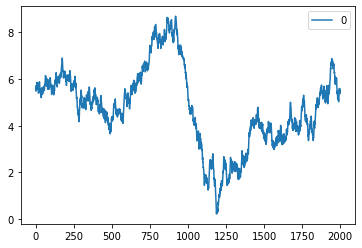

In [636]:
data.plot()

In [652]:
rounded_data = data.to_numpy()
rounded_data = [np.round(i) for i in rounded_data]
rounded_data = [int(i) for i in rounded_data]
rounded_data[0:5]

[6, 6, 5, 6, 6]

<AxesSubplot:>

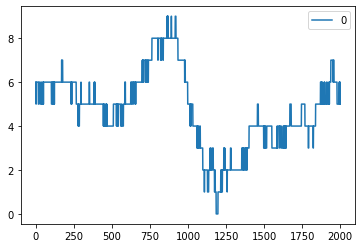

In [653]:
pd.DataFrame(rounded_data).plot()

In [654]:
Counter(rounded_data)

Counter({6: 393,
         5: 459,
         7: 128,
         4: 439,
         8: 152,
         9: 12,
         3: 164,
         2: 198,
         1: 43,
         0: 12})

In [655]:
mndata = MNIST('./Data')
images, labels = mndata.load_training()
labels = labels.tolist()
images = [x for _,x in sorted(zip(labels,images))]
labels.sort()

label_counts = list(Counter(labels).values())

tensor_shape = (N, 28, 28)
data_tensor = np.empty(tensor_shape)

for i in range(N):

    curr_num = rounded_data[i]

    # Pick a random number within that number range
    offset = sum(label_counts[:(curr_num)])
    ran_index = np.random.randint(offset, offset + label_counts[curr_num])

    # Set that random images inside our tensor
    tmp = np.asarray(images[ran_index])
    tmp.resize((tensor_shape[1], tensor_shape[2]))
    data_tensor[i] = tmp

array([6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6])

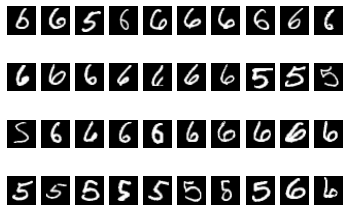

In [656]:
jts.implot_tensor(data_tensor, (4, 10))
np.array(rounded_data[0:40])

In [657]:
N_train = N - 10
N_test = N - N_train
print(f"N: {N}")
print(f"N_train: {N_train}")
print(f"N_test: {N_test}")

N: 2000
N_train: 1990
N_test: 10


In [658]:
train_tensor = jts.extract_train_tensor(data_tensor, N_train)
test_tensor = jts.extract_test_tensor(data_tensor, N_train, N_test)

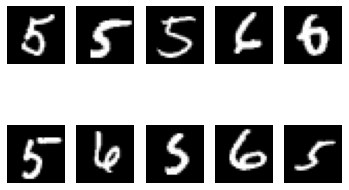

In [659]:
jts.implot_tensor(test_tensor, (2, 5))

In [660]:
train_dwt = jts.apply_dwt_to_tensor(train_tensor)

In [661]:
train_model_sets = jts.split_cols_into_model_sets(train_dwt, N_train)
test_model_sets = jts.split_cols_into_model_sets(test_tensor, N_test)

In [662]:
result_model_sets = np.empty((tensor_shape[2], N_test, tensor_shape[1]))
result_model_sets_diff = np.empty((tensor_shape[2], N_test, tensor_shape[1]))

for i in range(28):
    train_df = pd.DataFrame(train_model_sets[i])
    test_df = pd.DataFrame(test_model_sets[i])
    train_diff = train_df.diff().dropna()
    model = VAR(train_diff)
    fit = model.fit(1)

    test_df.columns = test_df.columns[:].astype(str)
    results_diff = jts.forecast(fit, train_diff, test_df, N_test, calc_conf = False)
    result_model_sets_diff[i] = results_diff
    result_model_sets[i] = jts.invert_diff_transformation(results_diff, train_df)

C:\Users\jacks\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\jacks\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\jacks\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\jacks\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.


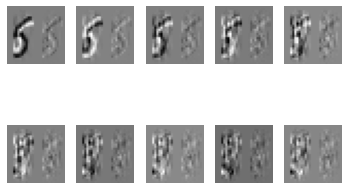

In [663]:
jts.implot_tensor(jts.collect_result_cols_into_tensor(result_model_sets_diff, N_test), (2, 5))

In [664]:
result_dwt_tensor = jts.collect_result_cols_into_tensor(result_model_sets, N_test)

In [665]:
result_tensor = jts.apply_inverse_dwt_to_tensor(result_dwt_tensor)

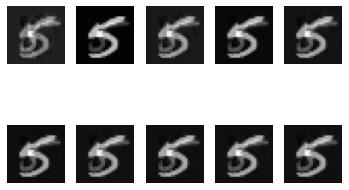

In [666]:
jts.implot_tensor(result_tensor, (2, 5))